## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Defing parameters for system - each described in cell



In [2]:
#Starting parameters

n = 250 #

#conversion factor from pixels to meters from experiment
pixel_to_metres = (1/75) * 10 ** (-5) 

#time step in Seconds
Dt = 1e-3

#Radius of bead in Meters
R = 2e-6 

#Temperature in Kelvin
T = 298

#viscosity of medium in Pascal-Seconds
eta = 0.001

#spring constant of trap in x, y and z in Newton per Meter
kx = 1e-6 
ky = 1e-6
kz = 0.1e-6

## Defining a function to simulate brownian motion

In [4]:
def brownian(Dt, R, T, eta):
    kB = 1.38e-23
    gamma = 6*np.pi*R*eta
    D = (kB*T) / gamma
    
    x = np.zeros(1000)
    y = np.zeros(1000)
    
    for i in range(len(x)):
        if i == 0:
            x[0] = 0
            y[0] = 0
        else:
            x[i] = x[i-1] + np.sqrt(2*D*Dt) * np.random.normal(0,1)
            y[i] = y[i-1] + np.sqrt(2*D*Dt) * np.random.normal(0,1)
    return x, y

## Defining a function to calculate mean square velocity of time steps

In [5]:
def velocity_fnc(x_data, Dt):
    v_array = np.zeros(len(x_data) - 1)
    for i in range(len(x_data) - 1):
        if i == 0:
            v_array[i] = 0
        else:
            v = (x_data[i+1] - x_data[i]) / Dt
            v_array[i] = v
    return v_array

## Defining Autocorrelation Function

In [6]:
def acf(v_data):
    skips = np.arange(1, len(v_data))
    
    acf = []
    for skip in skips:
        indices = np.arange(0, len(v_data), skip)
        new_v = v_data[indices]
        prod_v = new_v * v_data
        
        acf_v = np.mean(prod_v)

        acf.append(acf_v)
    return acf

## Plotting brownian motion for a range of bead size

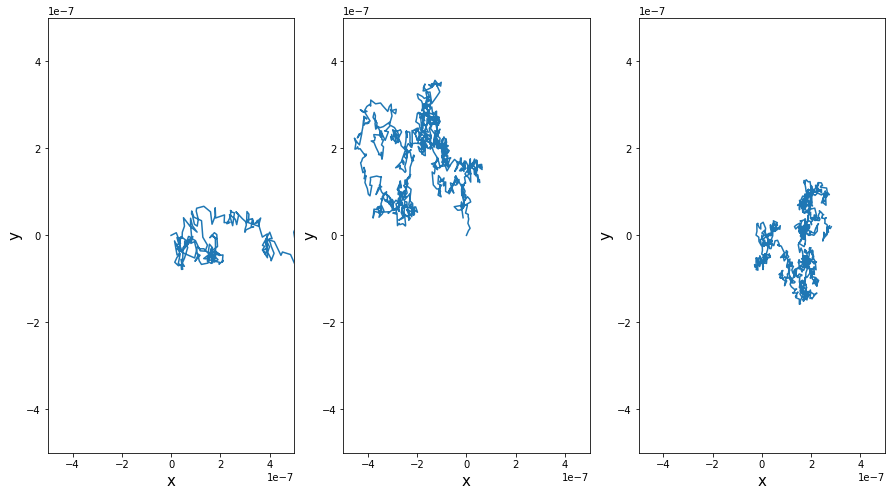

In [7]:
radii = [R, 2.5*R,  5*R]
fig, ax = plt.subplots(1,3, figsize=(15,8))
for i in range(3):
    x_path, y_path = brownian(Dt, radii[i], T, eta)
    ax[i].plot(x_path, y_path)
    ax[i].set_xlabel('x', fontsize=15)
    ax[i].set_ylabel('y', fontsize=15)
    ax[i].set_xlim(-5e-7, 5e-7)
    ax[i].set_ylim(-5e-7, 5e-7)


## Defining functions to:
 ### calculate differences between each point with error
 ### calculate mean square displacement with error
 ### fit a function to the msd

In [8]:
def calculate_differences(one_dimensional_array):
    a_length = len(one_dimensional_array)
    skips = np.arange(1, a_length)
    differences = []
    err_differences = []
    for i in skips:
        difference = np.diff(one_dimensional_array[np.arange(0, a_length, i)])
        err_diff = np.std(difference)
        differences.append(difference)
        err_differences.append(err_diff)
    return differences, err_differences

def calculate_r_square(one_dimensional_array, one_d_errs):
    one_d_mean_squared = []
    err_one_d_mean_sq = []
    for i in range(len(one_dimensional_array)):
        one_da_square = one_dimensional_array[i] ** 2
        err_one_da_square = np.std(one_da_square) / (np.sqrt(len(one_dimensional_array[i]) - 1))
        one_da_sq_mean = np.mean(one_da_square)
        one_d_mean_squared.append(one_da_sq_mean)
        err_one_d_mean_sq.append(err_one_da_square)
    return one_d_mean_squared, err_one_d_mean_sq

def line_of_best_fit_and(times, y_points, end_point):
    m, c = np.polyfit(times[0:end_point], y_points[0:end_point], 1)
    D = m / 2
    x_for_fit = np.linspace(0, 0.05, 1000)
    fit = m*x_for_fit + c
    n = 1.38*10**(-23)*298/(6*np.pi*D*2*10**(-6))
    return n, fit, x_for_fit

In [10]:
x_v = velocity_fnc(x_path, Dt)
# x_acf = acf(x_v)

In [11]:
#Calculating MSD
x_diff, x_diff_err = np.array(calculate_differences(x_path), dtype ='object')
y_diff, y_diff_err = np.array(calculate_differences(y_path), dtype = 'object')
x_sq_mean, x_sq_mean_err = calculate_r_square(x_diff, x_diff_err)
y_sq_mean, y_sq_mean_err = calculate_r_square(y_diff, y_diff_err)

#Frames per second
frames = np.arange(0, len(x_diff))
times = frames/1000

#Line of best fit 
x_n, fit, x_for_fit = line_of_best_fit_and(times, x_sq_mean, 50)

<ipython-input-8-51400583f1cd>:18: RuntimeWarning: invalid value encountered in double_scalars
  err_one_da_square = np.std(one_da_square) / (np.sqrt(len(one_dimensional_array[i]) - 1))


0.006452950714790698


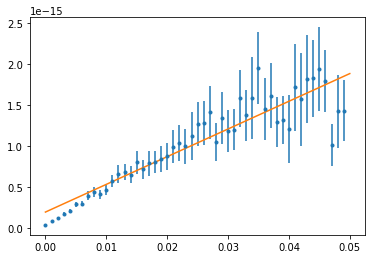

In [13]:
# plotting msd with line of best fit and errors
plt.errorbar(times[0:50], x_sq_mean[0:50], x_sq_mean_err[0:50], label='x', fmt='.')
plt.plot(x_for_fit, fit)
print(x_n)

## Optical Trap:

### Here I simulated an optical trap in 3 dimensions to overcome the limitations of measuring in 2 dimensions

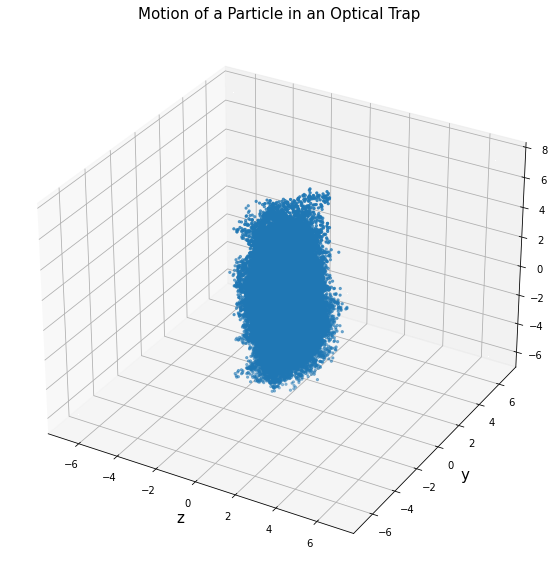

In [14]:
def trapped(Dt, R, T, eta, kx, ky, kz):
    kB = 1.38e-23
    gamma = 6*np.pi*R*eta
    D = (kB*T)/gamma
    
    x = np.zeros(100000)
    y = np.zeros(100000)
    z = np.zeros(100000)
    
    x[0] = 0
    y[0] = 0
    z[0] = 0
    
    for i in np.arange(1, len(x)):
        if x[i-1] == 0:
            x[i] = np.sqrt(2*D*Dt) * np.random.randn()
            y[i] = np.sqrt(2*D*Dt) * np.random.randn()
            z[i] = np.sqrt(2*D*Dt) * np.random.randn()
        else:
            #Deterministic step
            x[i] = x[i-1] - (kx*Dt)/(gamma) * x[i-1]
            y[i] = y[i-1] - (ky*Dt)/(gamma) * y[i-1]
            z[i] = z[i-1] - (kz*Dt)/(gamma) * z[i-1]

            #Diffusive step
            x[i] = x[i] + np.sqrt(2*D*Dt)*np.random.randn()
            y[i] = y[i] + np.sqrt(2*D*Dt)*np.random.randn()
            z[i] = z[i] + np.sqrt(2*D*Dt)*np.random.randn()
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection = '3d')
    ax.scatter(x,y,z, marker='.')
    ax.set_title('Motion of a Particle in an Optical Trap', fontsize=15)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_xlabel('z', fontsize=15)
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w', marker=',')
    
    plt.show()

    return x,y,z
        
array = trapped(Dt, R, T, eta, kx,ky,kz)

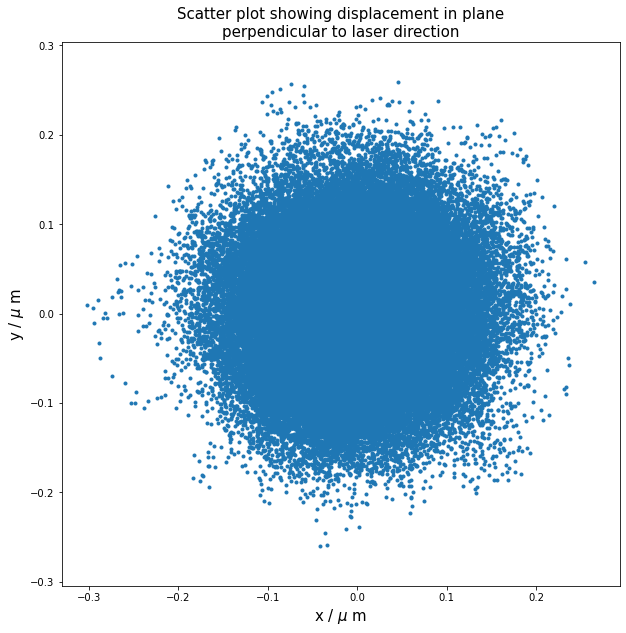

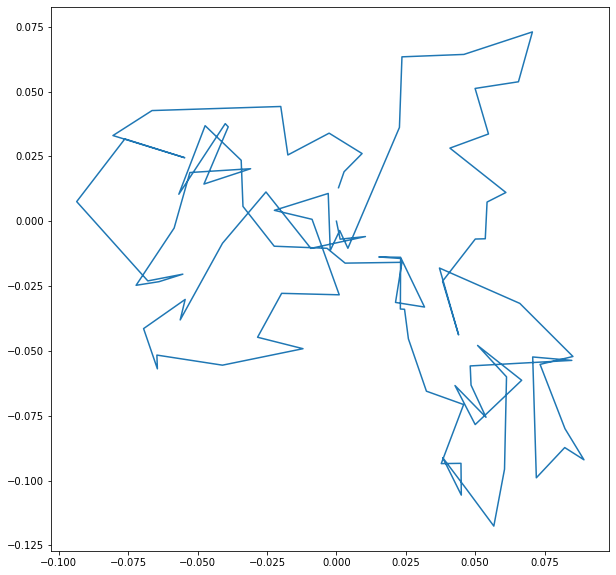

In [540]:
#Proving that optical trap in 2 dimensions is consistent with experiment

plt.figure(figsize=(10,10))
plt.scatter(array[0] * 10**6, array[1] * 10**6, marker='.')
plt.title('Scatter plot showing displacement in plane\nperpendicular to laser direction', fontsize=15)
plt.xlabel('x / $\mu$ m', fontsize=15)
plt.ylabel('y / $\mu$ m', fontsize=15)
plt.axis('equal')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(array[0][:100] * 10**6, array[1][:100] * 10**6)


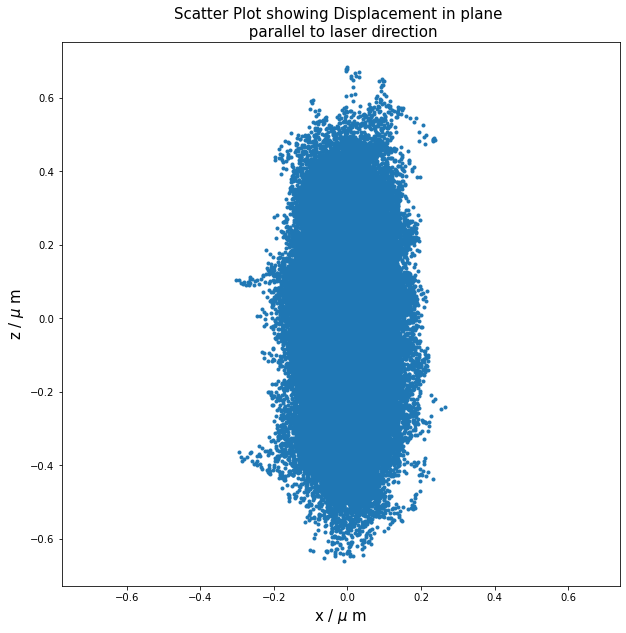

In [420]:
plt.figure(figsize=(10,10))
plt.scatter(array[0] * 10**6, array[2] * 10**6, marker='.')
plt.title('Scatter Plot showing Displacement in plane \n parallel to laser direction', fontsize=15)
plt.xlabel('x / $\mu$ m', fontsize=15)
plt.ylabel('z / $\mu$ m', fontsize=15)
plt.axis('equal')
plt.show()

## Radii:

### Applying this to beads of different sizes

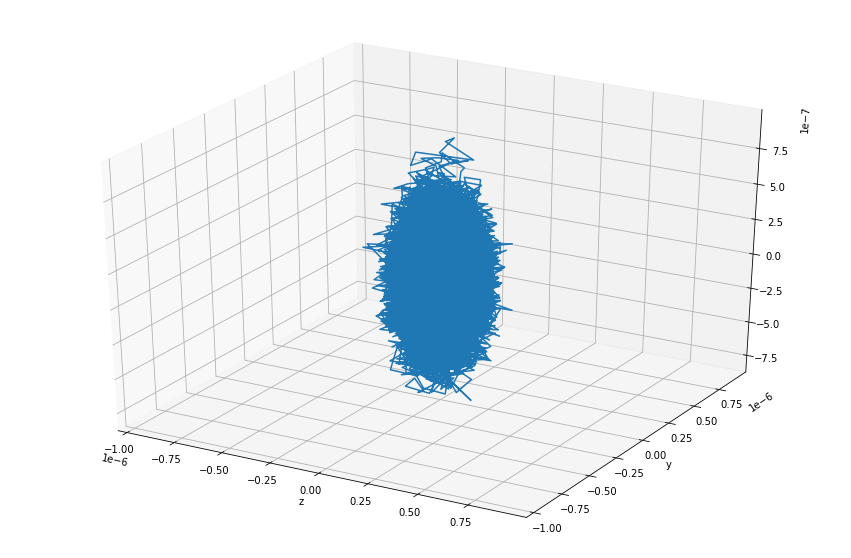

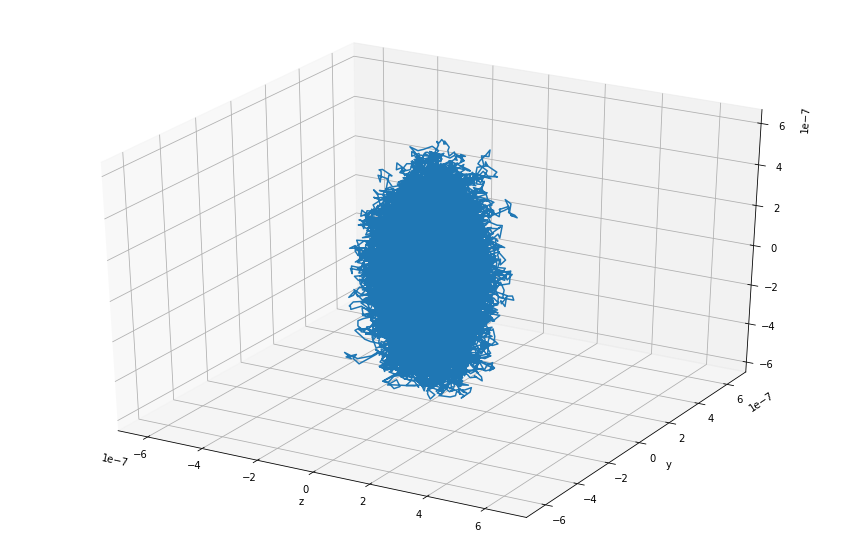

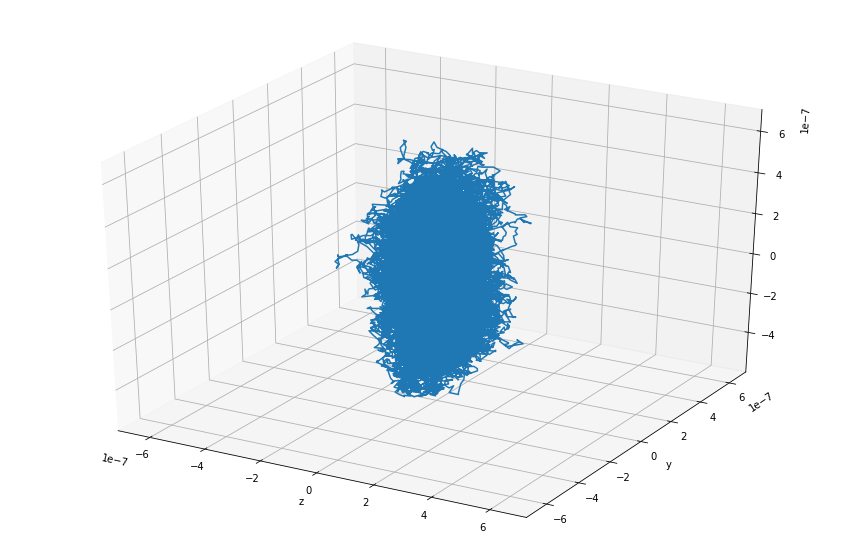

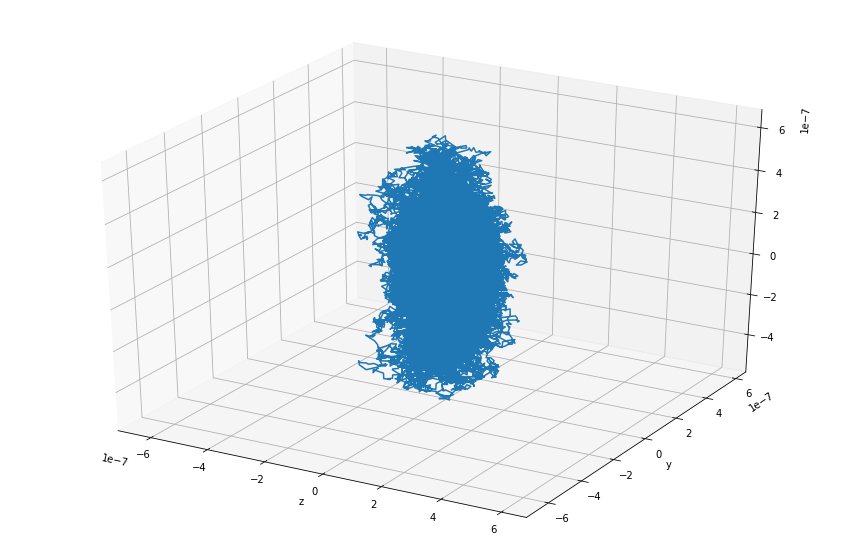

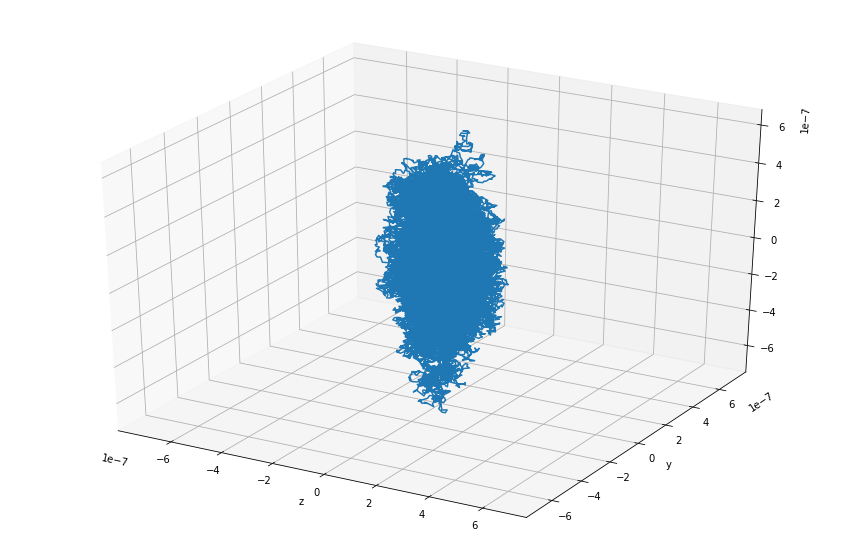

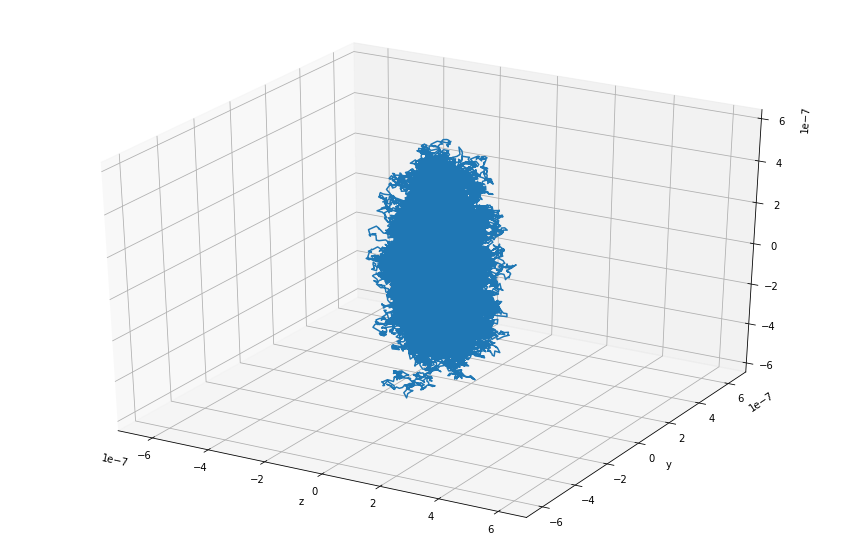

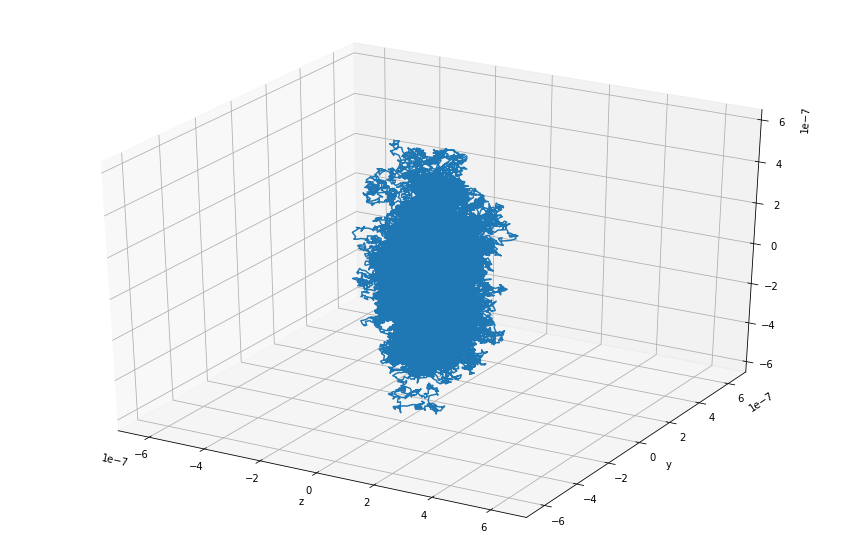

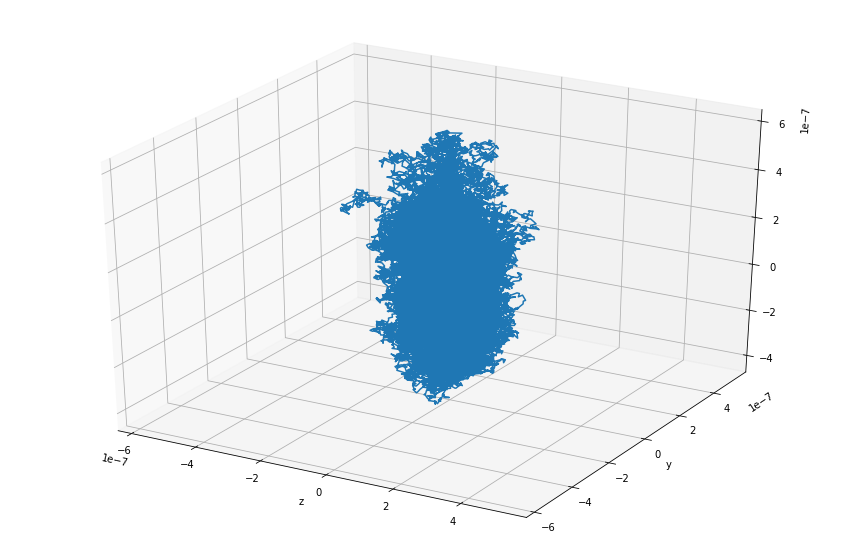

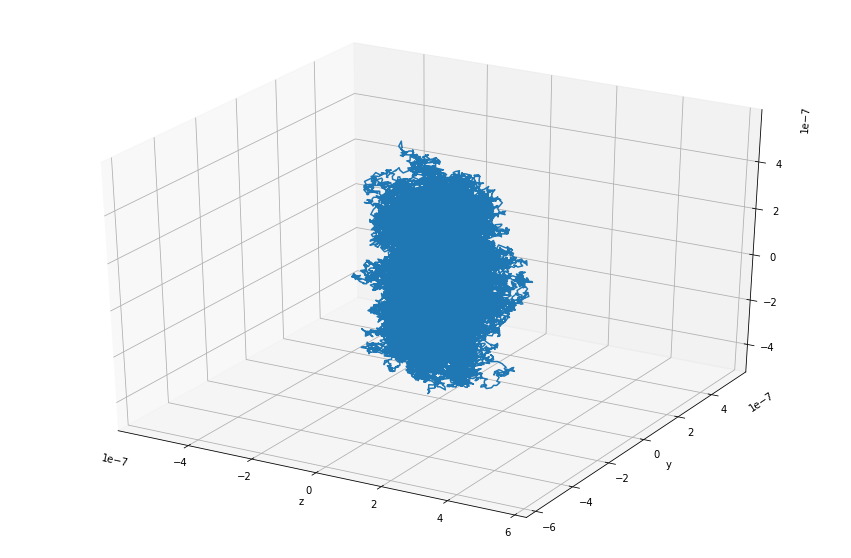

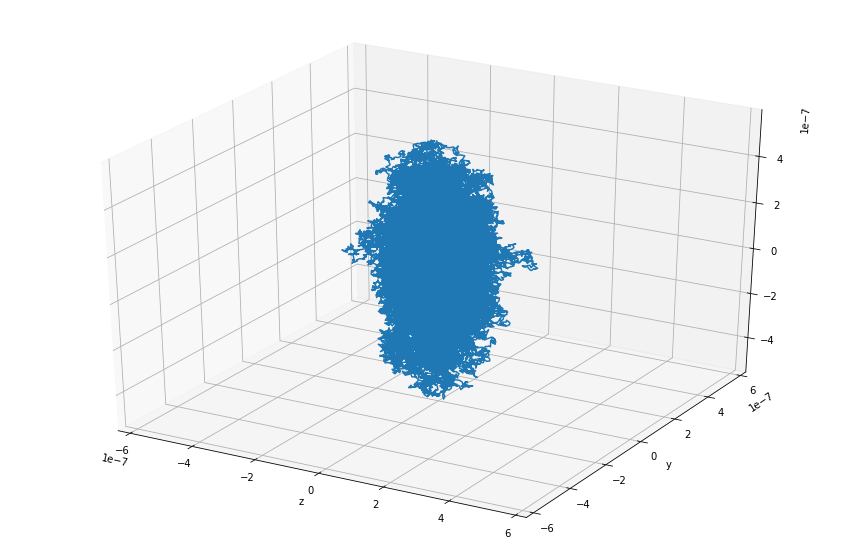

In [129]:
radius_array = np.linspace(0.1e-6, 10e-6, 10)
tracks_particles = []
for i in range(len(radius_array)):
    track = trapped(Dt, radius_array[i], T, eta, kx,ky,kz)
    tracks_particles.append(track)

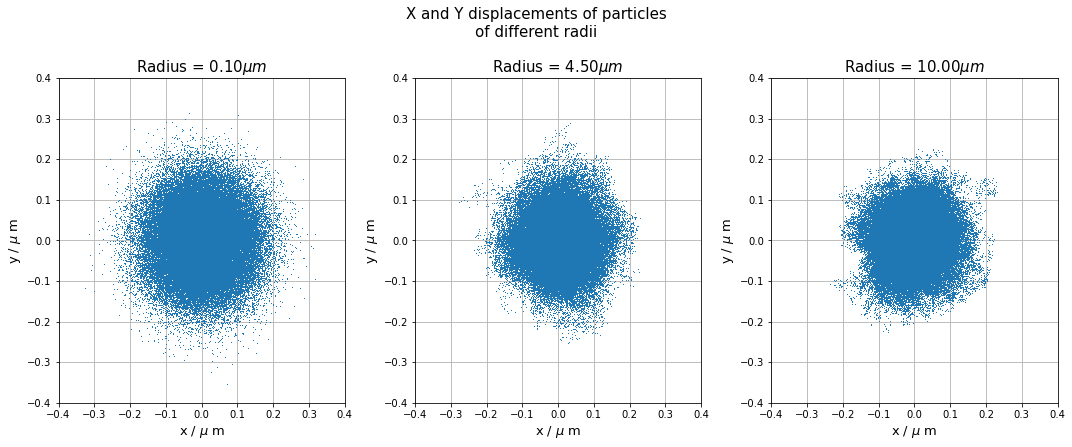

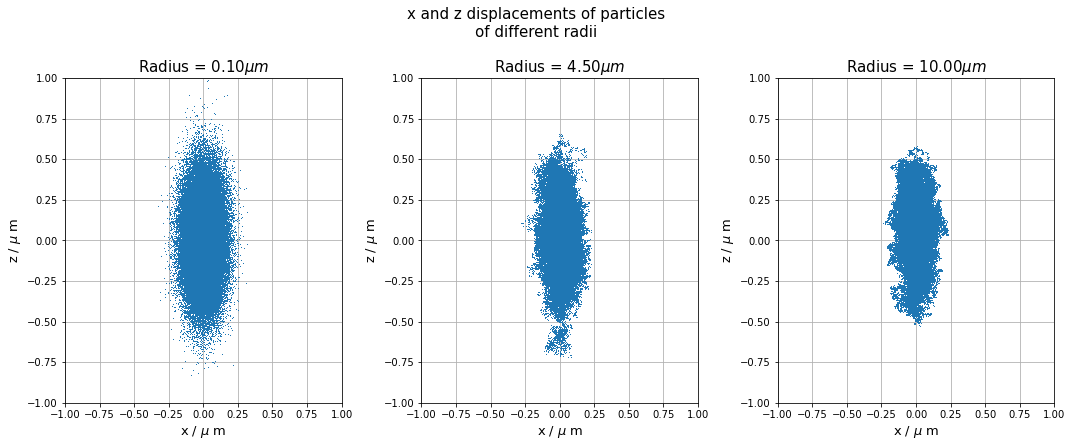

In [443]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
ax[0].plot(tracks_particles[0][0]  * 10**6, tracks_particles[0][1] * 10**6, ',')
for i in [0, 1 ,2]:
    ax[i].set_xlim(-0.4, 0.4)
    ax[i].set_ylim(-0.4, 0.4)
    ax[i].grid()
    ax[i].set_xlabel('x / $\mu$ m', fontsize=13)
    ax[i].set_ylabel('y / $\mu$ m', fontsize=13)
    
ax[1].plot(tracks_particles[4][0] * 10**6, tracks_particles[4][1] * 10**6, ',')
ax[2].plot(tracks_particles[9][0] * 10**6, tracks_particles[9][1] * 10**6, ',')
ax[0].set_title('Radius = {:.2f}$\mu m$'.format(radius_array[0] * 10**6), fontsize=15)
ax[1].set_title('Radius = {:.2f}$\mu m$'.format(radius_array[4] * 10**6), fontsize=15)
ax[2].set_title('Radius = {:.2f}$\mu m$'.format(radius_array[9] * 10**6), fontsize=15)
plt.suptitle('X and Y displacements of particles\nof different radii', fontsize=15)
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()


fig, ax = plt.subplots(1,3, figsize=(15,7))
for i in [0, 1 ,2]:
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-1, 1)
    ax[i].grid()
    ax[i].set_xlabel('x / $\mu$ m', fontsize=13)
    ax[i].set_ylabel('z / $\mu$ m', fontsize=13)
    
ax[0].plot(tracks_particles[0][0] * 10**6, tracks_particles[0][2] * 10**6, ',')
ax[1].plot(tracks_particles[4][0] * 10**6, tracks_particles[4][2] * 10**6, ',')
ax[2].plot(tracks_particles[9][0] * 10**6, tracks_particles[9][2] * 10**6, ',')
ax[0].set_title('Radius = {:.2f}$\mu m$'.format(radius_array[0] * 10**6), fontsize=15)
ax[1].set_title('Radius = {:.2f}$\mu m$'.format(radius_array[4] * 10**6), fontsize=15)
ax[2].set_title('Radius = {:.2f}$\mu m$'.format(radius_array[9] * 10**6), fontsize=15)
plt.suptitle('x and z displacements of particles\nof different radii', fontsize=15)
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()


## Const Force:

### Adding a constant force in one direction to offset the equilibrium position, eg gravity

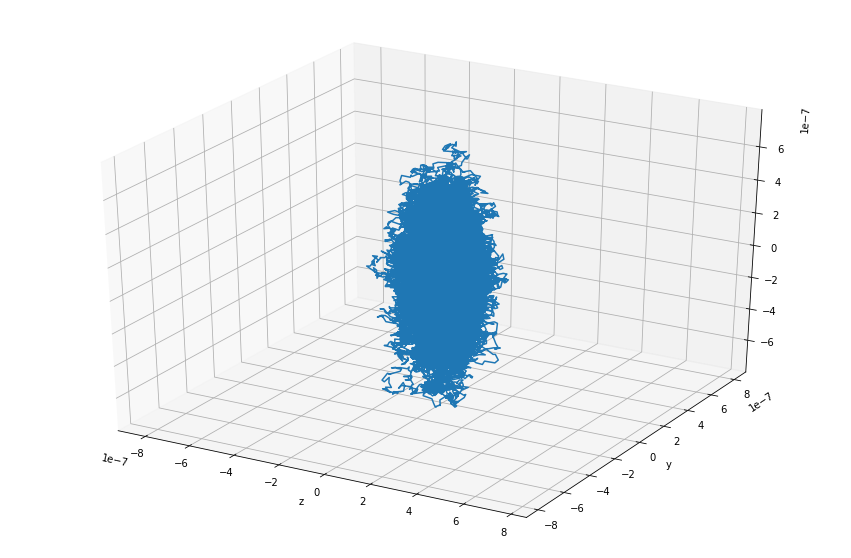

In [320]:
#normal trap
track = trapped(Dt, R, T, eta, kx,ky,kz)

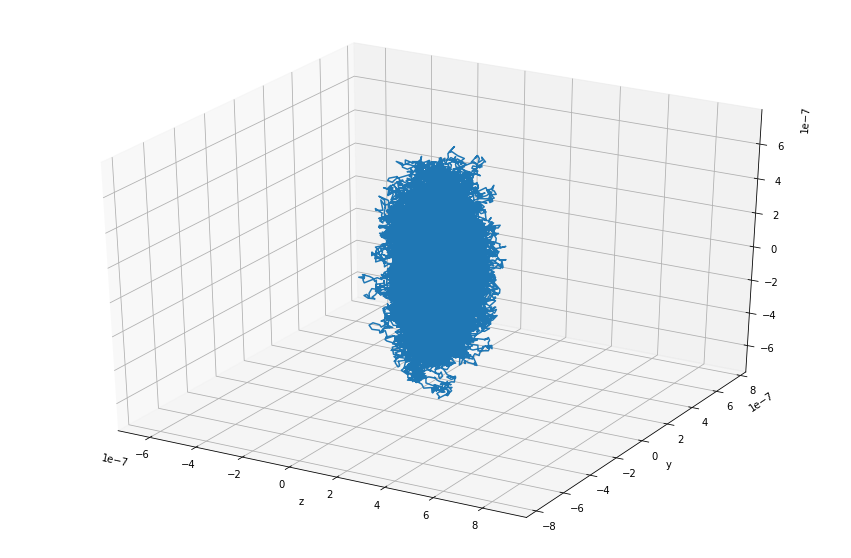

In [446]:
def const_force(Dt, R, T, eta, kx, ky, kz, force):
    kB = 1.38e-23
    gamma = 6*np.pi*R*eta
    D = (kB*T)/gamma
    
    x = np.zeros(100000)
    y = np.zeros(100000)
    z = np.zeros(100000)
    
    x[0] = 0
    y[0] = 0
    z[0] = 0
    
    for i in np.arange(1, len(x)):
        if x[i-1] == 0:
            x[i] = np.sqrt(2*D*Dt) * np.random.randn()
            y[i] = np.sqrt(2*D*Dt) * np.random.randn()
            z[i] = np.sqrt(2*D*Dt) * np.random.randn()
        else:
            #Deterministic step
            x[i] = x[i-1] - (kx*Dt)/(gamma) * x[i-1]
            y[i] = y[i-1] - (ky*Dt)/(gamma) * y[i-1]
            z[i] = z[i-1] - (kz*Dt)/(gamma) * z[i-1]

            #Diffusive step
            x[i] = x[i] + np.sqrt(2*D*Dt)*np.random.randn()
            y[i] = y[i] + np.sqrt(2*D*Dt)*np.random.randn()
            z[i] = z[i] + np.sqrt(2*D*Dt)*np.random.randn()
            
            #Constant Force
            x[i] = x[i] + force[0] * Dt
            y[i] = y[i] + force[1] * Dt
            z[i] = z[i] + force[2] * Dt
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection = '3d')
    ax.plot(x,y,z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlabel('z')
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    plt.show()

    return x,y,z
force = np.array([30,0,0]) * 10**-7
force_track = const_force(Dt, R, T, eta, kx,ky,kz, force)

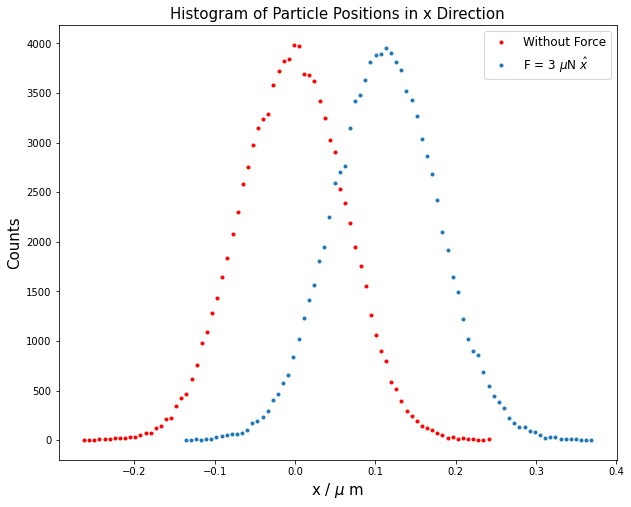

In [459]:
counts_x, bins_x = np.histogram(track[0], bins=80)
f_counts_x, f_bins_x = np.histogram(force_track[0], bins=80)
plt.figure(figsize=(10,8))
plt.plot(bins_x[:-1] * 10**6, counts_x, 'r.', label='Without Force')
plt.plot(f_bins_x[:-1] * 10**6, f_counts_x, '.', label = 'F = 3 $\mu$N $\hat{x}$')
plt.title('Histogram of Particle Positions in x Direction', fontsize=15)
plt.xlabel('x / $\mu$ m', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(prop={'size': 12})
plt.show()

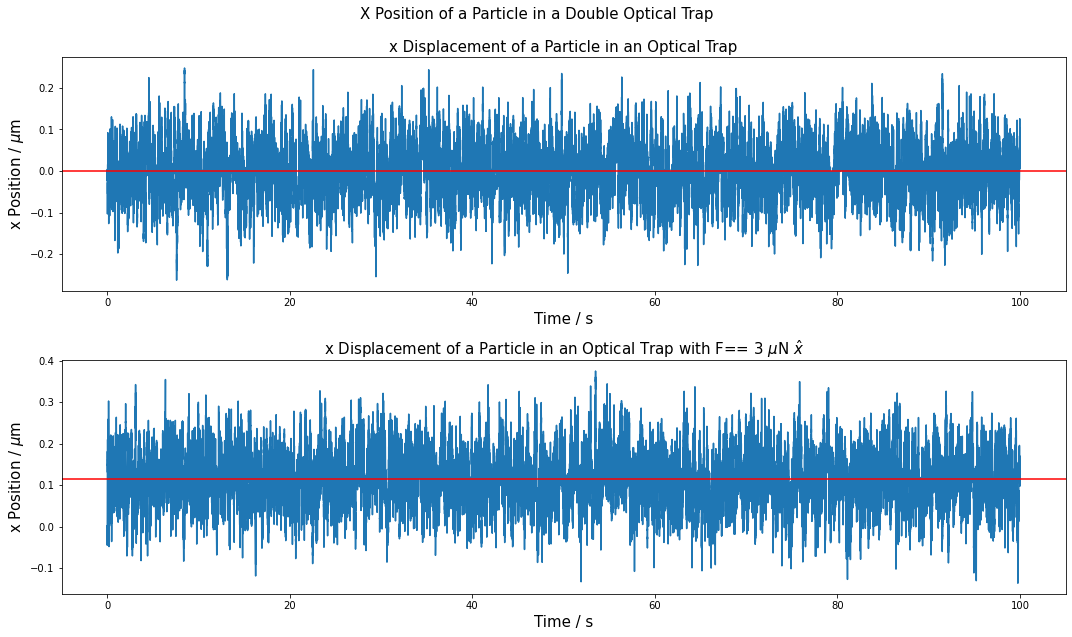

In [482]:
time = len(double_track[0]) * Dt
time_arr = np.linspace(0,time, len(double_track[0]))
f_avg = np.mean(force_track[0]) * 10**6
avg = np.mean(track[0]) * 10**6
fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[1].set_title('x Displacement of a Particle in an Optical Trap with F== 3 $\mu$N $\hat{x}$', fontsize=15)
ax[0].set_title('x Displacement of a Particle in an Optical Trap', fontsize=15)
ax[1].plot(time_arr, force_track[0]*10**6)
ax[0].plot(time_arr, track[0] * 10**6)
ax[1].axhline(f_avg, 0, 1, c='r')
ax[0].axhline(avg, 0, 1, c='r')
for i in range(2):
    ax[i].set_xlabel('Time / s', fontsize=15)
    ax[i].set_ylabel('x Position / $\mu$m', fontsize=15)
plt.suptitle('X Position of a Particle in a Double Optical Trap', fontsize=15)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

## Double Trap 

### Simulating two optical traps - overcoming limitations of physical experiment
$$ U = \frac{ax^4}{4} - \frac{bx^2}{2} $$
$$ F = -ax^3 + bx $$

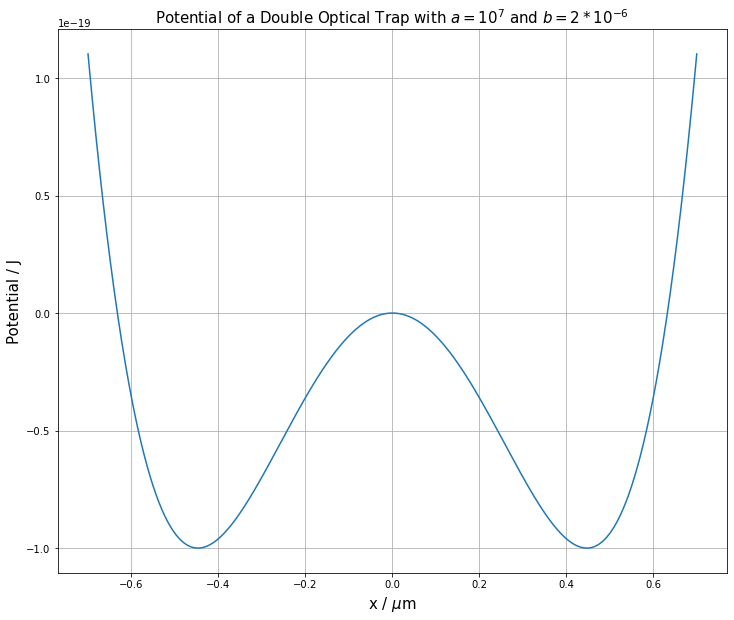

In [508]:
def potential(a, b, x):
    return (a*x**4 / 4) - (b*x**2 / 2)

x = np.linspace(-7e-7,7e-7,1000)
y = potential(10**7, 2*10**-6, x)
plt.figure(figsize=(12,10))
plt.xlabel('x / $\mu$m', fontsize=15)
plt.ylabel('Potential / J', fontsize=15)
plt.title('Potential of a Double Optical Trap with $a=10^7$ and $b=2*10^{-6}$', fontsize=15)
plt.grid()
plt.plot(x * 10**6,y)
plt.show()

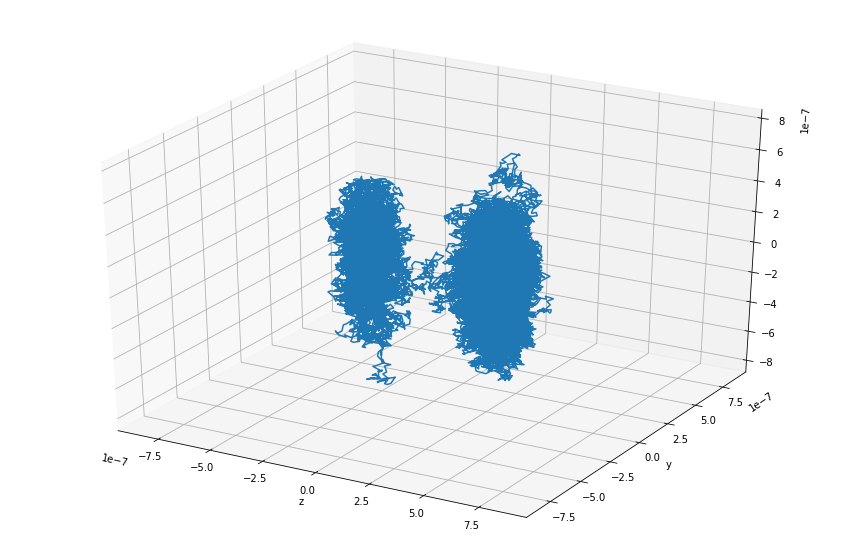

In [196]:
def double_trap(Dt, R, T, eta, kx, ky, kz, a, b):
    kB = 1.38e-23
    gamma = 6*np.pi*R*eta
    D = (kB*T)/gamma
    
    x = np.zeros(100000)
    y = np.zeros(100000)
    z = np.zeros(100000)
    
    x[0] = 0
    y[0] = 0
    z[0] = 0
    
    for i in np.arange(1, len(x)):
        if x[i-1] == 0:
            x[i] = np.sqrt(2*D*Dt) * np.random.randn()
            y[i] = np.sqrt(2*D*Dt) * np.random.randn()
            z[i] = np.sqrt(2*D*Dt) * np.random.randn()
        else:
            #Deterministic step
            x[i] = x[i-1] + ((Dt)/(gamma) * (-a*(x[i-1])**3 + b*x[i-1]))
            y[i] = y[i-1] - (ky*Dt)/(gamma) * y[i-1]
            z[i] = z[i-1] - (kz*Dt)/(gamma) * z[i-1]

            #Diffusive step
            x[i] = x[i] + np.sqrt(2*D*Dt)*np.random.randn()
            y[i] = y[i] + np.sqrt(2*D*Dt)*np.random.randn()
            z[i] = z[i] + np.sqrt(2*D*Dt)*np.random.randn()
            
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection = '3d')
    ax.plot(x,y,z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlabel('z')
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    plt.show()

    return x,y,z
double_track = double_trap(Dt, R, T, eta, kx, ky, kz, 10**7, 10**-6)

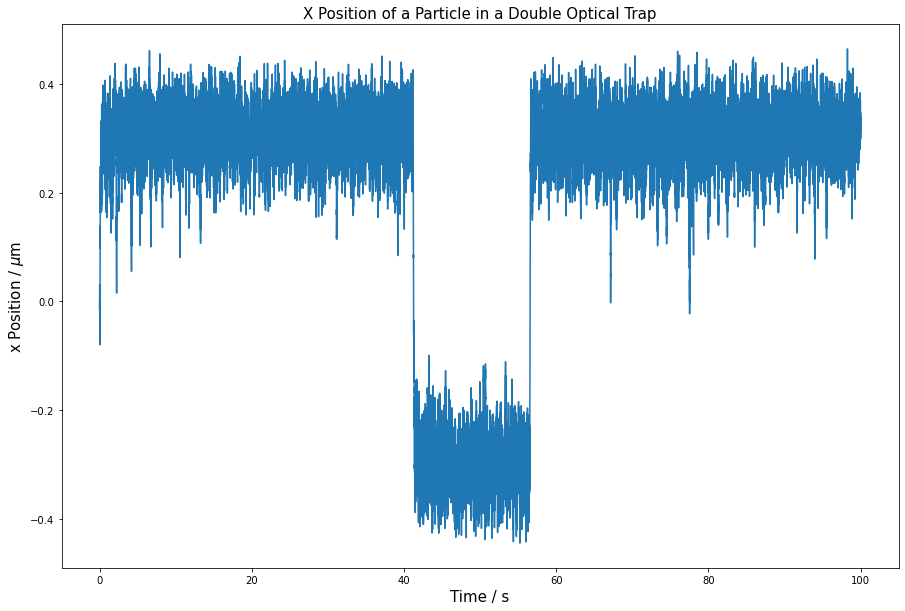

In [208]:

time = len(double_track[0]) * Dt
time_arr = np.linspace(0,time, len(double_track[0]))
plt.figure(figsize=(15,10))
plt.plot(time_arr, double_track[0]*10**6)
plt.xlabel('Time / s', fontsize=15)
plt.ylabel('x Position / $\mu$m', fontsize=15)
plt.title('X Position of a Particle in a Double Optical Trap', fontsize=15)
plt.show()

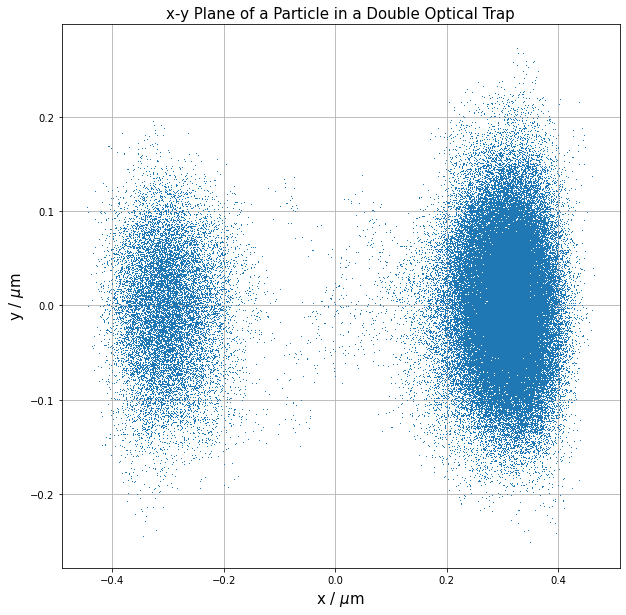

In [451]:
plt.figure(figsize=(10,10))
plt.plot(double_track[0] * 10**6, double_track[1] * 10**6, ',')
plt.title('x-y Plane of a Particle in a Double Optical Trap', fontsize=15)
plt.xlabel('x / $\mu$m', fontsize=15)
plt.grid()
plt.ylabel('y / $\mu$m', fontsize=15)
plt.show()

## Gamma Gradient:

### Adding a viscosity gradient - overcoming experiment limitations
$$ \gamma = \gamma_i + 4e^8(x + y +z)) $$

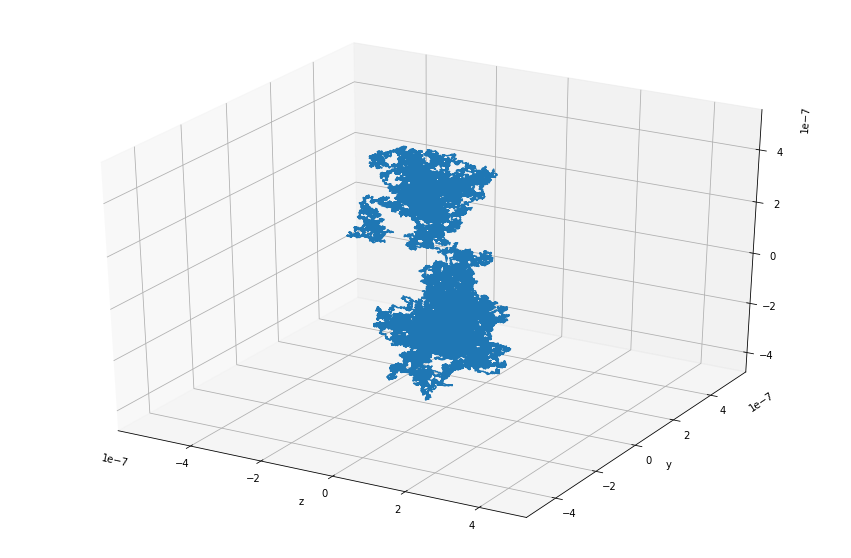

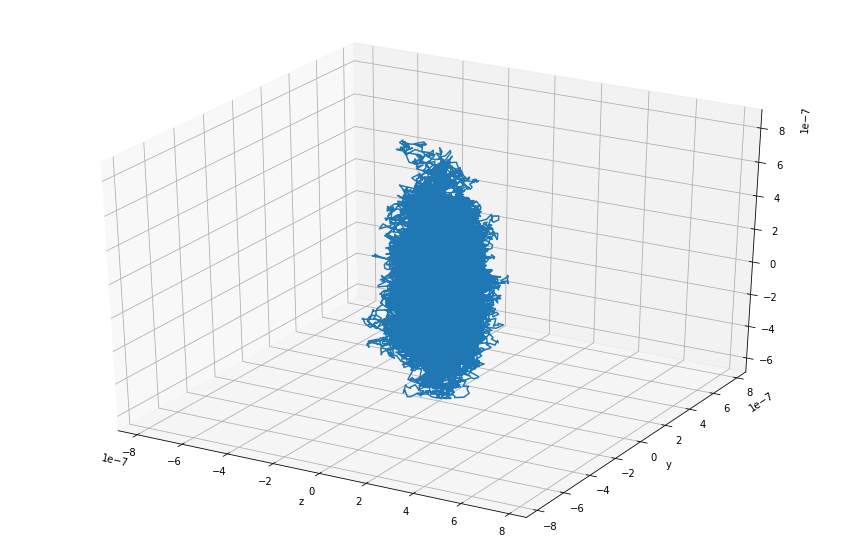

In [341]:
def gamma_space(g_i, x, y, z):
    G = g_i * (1 + (4e8 *(abs(x) + abs(y) + abs(z))))
    return G

def non_const_G(Dt, R, T, eta, kx, ky, kz):
    kB = 1.38e-23
    gamma_i = 6*np.pi*R*eta
    D = (kB*T)/gamma_i

    x = np.zeros(100000)
    y = np.zeros(100000)
    z = np.zeros(100000)
    
    x[0] = 0
    y[0] = 0
    z[0] = 0
    
    for i in np.arange(1, len(x)):
        if x[i-1] == 0:
            x[i] = np.sqrt(2*D*Dt) * np.random.randn()
            y[i] = np.sqrt(2*D*Dt) * np.random.randn()
            z[i] = np.sqrt(2*D*Dt) * np.random.randn()
        else:
            #Deterministic step
            gamma = gamma_space(gamma_i, x[i-1], y[i-1], 0)
            x[i] = x[i-1] - (kx*Dt)/(gamma) * x[i-1]
            y[i] = y[i-1] - (ky*Dt)/(gamma) * y[i-1]
            z[i] = z[i-1] - (kz*Dt)/(gamma) * z[i-1]

            #Diffusive step
            D = kB*T / gamma
            x[i] = x[i] + np.sqrt(2*D*Dt)*np.random.randn()
            y[i] = y[i] + np.sqrt(2*D*Dt)*np.random.randn()
            z[i] = z[i] + np.sqrt(2*D*Dt)*np.random.randn()
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection = '3d')
    ax.plot(x,y,z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlabel('z')
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    plt.show()

    return x,y,z

track_G = non_const_G(Dt, R, T, eta, kx, ky, kz)
track = trapped(Dt, R, T, eta, kx, ky, kz)

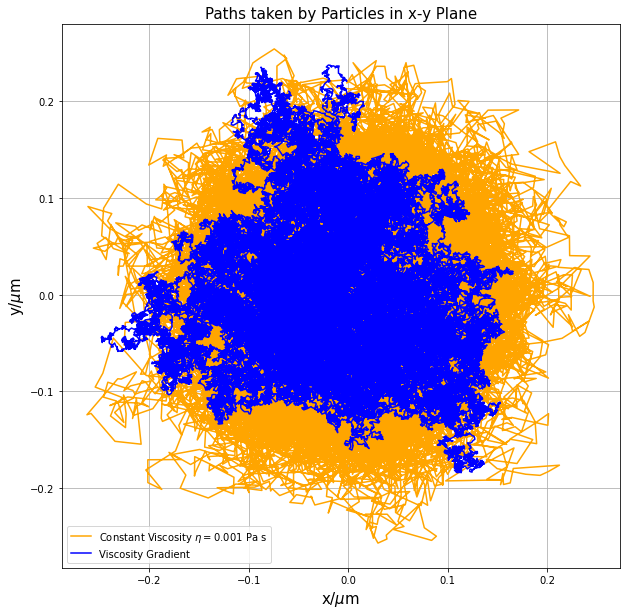

In [571]:
plt.figure(figsize=(10,10))
plt.plot(track[0] * 10**6, track[1] * 10**6, 'orange', label=('Constant Viscosity $\eta = 0.001$ Pa s'))
plt.plot(track_G[0] * 10**6, track_G[1] * 10**6, 'b', label=('Viscosity Gradient'))
plt.title('Paths taken by Particles in x-y Plane', fontsize=15)
plt.xlabel('x/$\mu$m', fontsize=15)
plt.grid()
plt.ylabel('y/$\mu$m', fontsize=15)
plt.legend()
plt.show()


## Rotational Force:
### Adding a rotational force (eg  RHS polarised light) to overcome limitations of experiment
$$ F = (-k_x x - \gamma \Omega y)\hat{x} + (\gamma \Omega x - k_y y) \hat{y}$$

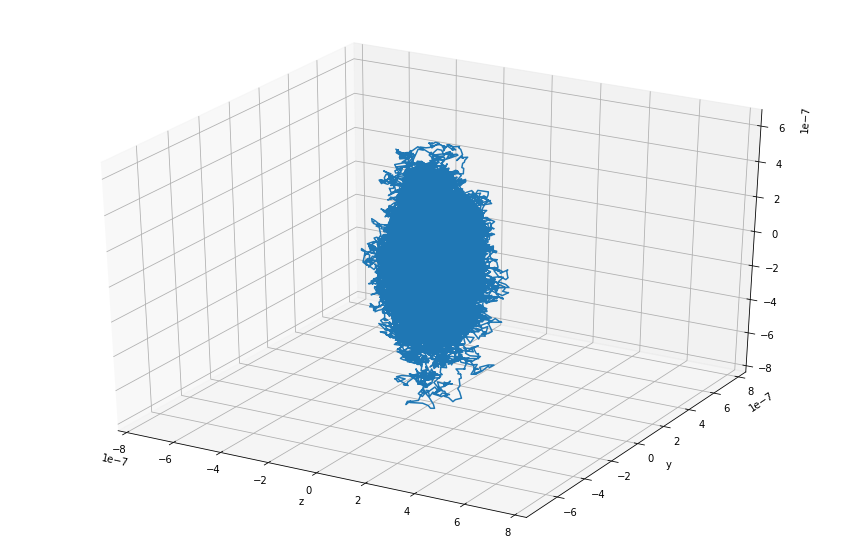

In [569]:
def rotational(Dt, R, T, eta, kx, ky, kz, omega):
    kB = 1.38e-23
    gamma = 6*np.pi*R*eta
    D = (kB*T)/gamma

    x = np.zeros(100000)
    y = np.zeros(100000)
    z = np.zeros(100000)
    
    x[0] = 0
    y[0] = 0
    z[0] = 0
    
    for i in np.arange(1, len(x)):
        if x[i-1] == 0:
            x[i] = np.sqrt(2*D*Dt) * np.random.randn()
            y[i] = np.sqrt(2*D*Dt) * np.random.randn()
            z[i] = np.sqrt(2*D*Dt) * np.random.randn()
        else:
            #Deterministic step
            x[i] = x[i-1] + ((Dt)/(gamma) * (-kx*x[i-1] - gamma*omega*y[i-1]))
            y[i] = y[i-1] + ((Dt)/(gamma) * (-ky*y[i-1] + gamma*omega*x[i-1]))
            z[i] = z[i-1] - (kz*Dt)/(gamma) * z[i-1]

            #Diffusive step
            x[i] = x[i] + np.sqrt(2*D*Dt)*np.random.randn()
            y[i] = y[i] + np.sqrt(2*D*Dt)*np.random.randn()
            z[i] = z[i] + np.sqrt(2*D*Dt)*np.random.randn()
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection = '3d')
    ax.plot(x,y,z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlabel('z')
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    plt.show()

    return x,y,z

rot_track = rotational(Dt, R, T, eta, kx, ky, kz, 0)

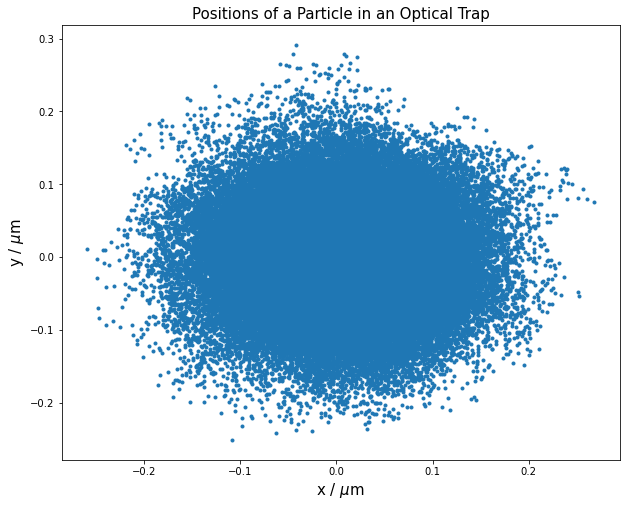

In [570]:
plt.figure(figsize=(10,8))
plt.plot(rot_track[0] * 10**6, rot_track[1]*10**6, '.')
plt.xlabel('x / $\mu$m', fontsize=15)
plt.ylabel('y / $\mu$m', fontsize=15)
plt.title('Positions of a Particle in an Optical Trap', fontsize=15)
plt.show()